In [7]:
#What is the minimum radius of a big triangle that can fit in all the provided smaller circles?
#min J = 0.5 * y_up * x_h
#such that:
#         for all i,j: (xi - xj)^2 + (yi - yj)^2 >= (ri + rj)^2
#         for all i:   yi*x_up - xi * y_up <= 0 (circles are below the vertex of the triangle)
#         for all i:   yi*(x_h - x_up) + y_up * (xi - xh) <= 0 (   "   )
#         for all i:   (y_i*x_up - xi*y_up)^2 >= (x_up^2 + y_up^2)^2 * R^2 (distance between center of circles and the line is greater than the radius of the circle)
#         for all i:   (yi*(x_h - x_up) + y_up * (xi - xh))^2 >= ((x_h -x_up)^2 + y_up^2)^2 * R^2 (   "     "     )

#Note: The lines that govern the sides of the triangle are:
#      x = 0
#     (y - y_up) = (y_up / x_up) * (x - x_up)
#     (y - y_up) = ((y_up - 0)/ (x_up - xh)) * (x - x_up)  

In [8]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random

In [9]:
model = AbstractModel()
model.i = Set()
model.j = Set(initialize=model.i)
model.R = Param(model.i)

def lowband(model,i):
    return (model.R[i],40)

model.x = Var(model.i, bounds=lowband, within=NonNegativeReals, initialize=random.uniform(0,100))
model.y = Var(model.i, bounds=lowband, within=NonNegativeReals, initialize=random.uniform(0,100))
model.xup = Var(bounds=(1,40), within=NonNegativeReals, initialize=40)
#height and base length of triangle
model.yup = Var(bounds=(1,40), within=NonNegativeReals, initialize=40)
model.xh = Var(bounds=(1,40), within=NonNegativeReals, initialize=40)
model.area = Var(bounds=(1,4000), within=NonNegativeReals, initialize=40)


def rule_eq1(model,i,j):
    if i!=j:
        return (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >= (model.R[i] + model.R[j])**2
    else:
        return Constraint.Skip;
model.eq1 = Constraint(model.i, model.j, rule=rule_eq1)

def rule_eq2(model,i):
    return model.y[i]*model.xup - model.x[i]*model.yup <= 0
model.eq2 = Constraint(model.i, rule=rule_eq2)

def rule_eq3(model,i):
    return model.y[i]*(model.xh - model.xup) + model.yup*(model.x[i] - model.xh) <= 0
model.eq3 = Constraint(model.i, rule=rule_eq3)

def rule_eq4(model,i):
    return (model.y[i]*model.xup - model.x[i]*model.yup)**2 >= (model.xup**2 + model.yup**2)*(model.R[i]**2)
model.eq4 = Constraint(model.i, rule=rule_eq4)

def rule_eq5(model,i):
    return (model.y[i]*(model.xh - model.xup) + model.yup*(model.x[i] - model.xh))**2 >= ((model.xh - model.xup)**2 + (model.yup)**2)*(model.R[i]**2)
model.eq5 = Constraint(model.i, rule=rule_eq5)

def rule_eq6(model,i):
    return model.y[i] <= model.yup-model.R[i]
model.eq6 = Constraint(model.i, rule=rule_eq6)

def rule_eq7(model):
    return model.xup <= model.xh
model.eq7 = Constraint(rule=rule_eq7)

model.obj = Objective(expr=0.5*(model.yup*model.xh), sense=minimize)

In [10]:
opt = SolverFactory('ipopt')
instance = model.create_instance("ExRadius.dat")
results = opt.solve(instance) #solves and updates instance

WARNING (W1002): Setting Var 'x[1]' to a numeric value `42.39514665241747`
    outside the bounds (2, 40).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[1]' to a numeric value `42.39514665241747`
    outside the bounds (2, 40).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[2]' to a numeric value `42.39514665241747`
    outside the bounds (1.2, 40).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[3]' to a numeric value `42.39514665241747`
    outside the bounds (1.8, 40).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[4]' to a numeric value `42.39514665241747`
    outside the bounds (0.9, 40).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[5]' to a numeric value `42.39514665241747`
    outside the bounds (3.2, 40).


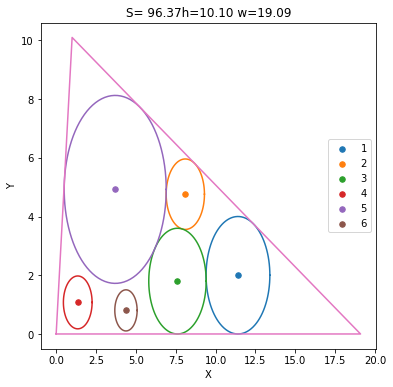

In [11]:
#f, ax = plt.subplot(1,1)
fig = plt.figure(figsize=(6,6))
theta = np.linspace(0, 2*np.pi, 100)
for i in instance.i:
    plt.scatter(value(instance.x[i]), value(instance.y[i]), label=str(i), s=30)
    Xc = value(instance.x[i]) + value(instance.R[i])*np.cos(theta)
    Yc = value(instance.y[i]) + value(instance.R[i])*np.sin(theta)
    plt.plot(Xc, Yc)

Xc = [0, value(instance.xup), value(instance.xh), 0]
Yc = [0, value(instance.yup), 0, 0]
plt.plot(Xc, Yc)
plt.legend(loc='right')
#plt.scatter(value(instance.Radius), 0,color='black',label='Centre', s=30)
plt.title('S= '+ str("%5.2f"% value(instance.obj)) + 'h='+ str("%5.2f"% value(instance.yup))+' w='+ str("%5.2f"% value(instance.xh)))
#plt.legend(loc='right')
#plt.axis('off')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [12]:
instance.display()
#instance.load(results) #Loading solution into results object
print(results.solver.status)

Model unknown

  Variables:
    x : Size=6, Index=i
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          1 :     2 : 11.402764320934699 :    40 : False : False : NonNegativeReals
          2 :   1.2 :  8.100214021722811 :    40 : False : False : NonNegativeReals
          3 :   1.8 :  7.608031146805382 :    40 : False : False : NonNegativeReals
          4 :   0.9 : 1.3532690887640078 :    40 : False : False : NonNegativeReals
          5 :   3.2 : 3.7032560322111023 :    40 : False : False : NonNegativeReals
          6 :   0.7 :  4.377899025018685 :    40 : False : False : NonNegativeReals
    y : Size=6, Index=i
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          1 :     2 :                2.0 :    40 : False : False : NonNegativeReals
          2 :   1.2 : 4.7593505760150645 :    40 : False : False : NonNegativeReals
          3 :   1.8 :                1.8 :    40 : False : False : NonNegativeReals
          4 :   0.9 